In [1]:
import numpy as np

import matplotlib.pyplot as plt

# [TODO][IMPORTANT] Always, the convergence of solution with respect to the time steps is crucial

In [2]:
def f(t,x):
    return x

def dx_df(t,x):
    return 1.0

In [3]:
from numpy import exp
def xt_ana(t, x0):
    return x0 * exp(t-t[0])

In [4]:
DELTA_T_SETUP_MAX_ITER_NUM = 50
DELTA_T_REDUCTION_RATIO = 0.5

In [5]:
def find_dt(tn, xn, dx_df, dt_max, DELTA_T_SETUP_MAX_ITER_NUM, 
            DELTA_T_REDUCTION_RATIO):
    """Find time to proceed by the implicit Euler method
    
    Notes
    -----
    This routine find a time to proceed `delta_t` that satisfies
    `1.0 - _delta_t * dx_df(tn+_delta_t, xn) > 0`
    """
    
    # Iterate until the criterion is fulfilled
    _dt = dt_max
    for _i in range(DELTA_T_SETUP_MAX_ITER_NUM):
        if 1.0 - _dt * dx_df(tn+_dt, xn) > 0.0: break
        _dt *= DELTA_T_REDUCTION_RATIO
        
    # Check iteration has been completed normally
    if _i == DELTA_T_SETUP_MAX_ITER_NUM - 1: 
        _msg = "DELTA_T_SETUP_MAX_ITER_NUM(={}) reached"
        raise Exception(_msg.format(DELTA_T_SETUP_MAX_ITER_NUM))
    elif _i > DELTA_T_SETUP_MAX_ITER_NUM - 1: 
        _msg = ("Unexpected case: index exceeded "
                "DELTA_T_SETUP_MAX_ITER_NUM(={})")
        raise Exception(_msg.format(DELTA_T_SETUP_MAX_ITER_NUM))
        
    # Return the result
    return _dt

# [TODO] Possible improvement:

- the initial guess when finding the root during `find_dx()`
- put `jac` for finding root during `find_dx()`

In [6]:
from scipy.optimize import root

def find_dx(f, tn, xn, dt):
    """Find `dx` such that `x_{n+1} = x_{n} + dx`"""
    
    def _g(_dx, _f, _tn, _xn, _dt):
        return -_dx + _dt * _f(_tn+_dt,_xn+_dx)
    _dx0 = 0.0
    _g_args = (f, tn, xn, dt)
    _sol = root(_g, _dx0, args=_g_args, method='hybr', jac=None, 
                options={'xtol':1.49012e-08, 'maxfev':0, 'factor':100})
    
    if _sol.success: return _sol.x
    else: raise RuntimeError(
        "Failed to find `dx` with result:\n{}".format(_sol))

# Solve

In [7]:
t0 = 0.0
dt = 0.05
N_t = 101

xp_t0_arr = np.array([-0.5, 0.0, 1.0, 1.5])

In [8]:
t_arr = t0 + dt * np.arange(N_t)

xp_arr = xp_t0_arr.copy()

xp_t_arr = np.empty((t_arr.size, xp_arr.size), dtype=float)
xp_t_arr[0,:] = xp_t0_arr

Nt, Np = t_arr.size, xp_arr.size

In [9]:
for nt in range(t_arr.size-1):
    _t = t_arr[nt]
#     _dt_max = t_arr[nt+1] - t_arr[nt]
    for nt_sub in range(DELTA_T_SETUP_MAX_ITER_NUM):
        _reach_next_t = True
        _dt = t_arr[nt+1] - _t
        for xp in xp_arr:
            for nt_sub_sub in range(DELTA_T_SETUP_MAX_ITER_NUM):
                if 1.0 - _dt*dx_df(t_arr[nt]+_dt,xp) > 0.0: break
                _reach_next_t = False
                _dt *= DELTA_T_REDUCTION_RATIO
        for ip in range(xp_arr.size):
            _dx = find_dx(f, _t, xp_arr[ip], _dt)
            xp_arr[ip] += _dx
        _t += _dt
        if _reach_next_t: break
    xp_t_arr[nt+1,:] = xp_arr

In [10]:
xp_t_ana_arr = np.empty_like(xp_t_arr)
for ip in range(Np):
    xp_t_ana_arr[:,ip] = xt_ana(t_arr, xp_t_arr[0,ip])

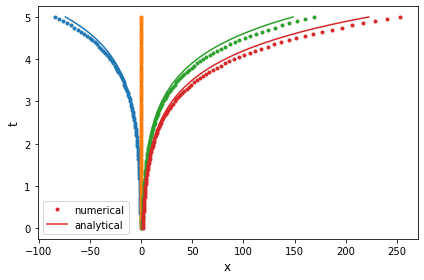

In [11]:
fig, ax = plt.subplots()
for ip in range(Np):
    l_num, = ax.plot(xp_t_arr[:,ip], t_arr, '.')
    l_ana, = ax.plot(xp_t_ana_arr[:,ip],t_arr, color=l_num.get_color())
ax.set_xlabel("x"), ax.set_ylabel("t")
ax.legend([l_num,l_ana], ["numerical", "analytical"])
fig.tight_layout()
# fig.savefig("f=x-with-dt-{}-test-3.png".format(dt))